# 1-S6: SHAP 기초

모델의 예측을 설명하는 SHAP (SHapley Additive exPlanations)을 학습합니다.

## 학습 목표
1. **SHAP 개념** - Shapley Value 기반 설명
2. **Explainer 종류** - TreeExplainer, DeepExplainer, KernelExplainer
3. **SHAP 시각화** - summary_plot, waterfall_plot, force_plot
4. **FDS 적용** - 사기 탐지 결과 설명

## 예상 시간
약 25분

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# SHAP JS 시각화 초기화
shap.initjs()

# 헬퍼 함수: SHAP 버전 호환성
def get_base_value(explainer):
    """SHAP expected_value를 스칼라로 반환 (버전 호환)"""
    ev = explainer.expected_value
    if hasattr(ev, '__len__'):
        return float(ev[0])
    return float(ev)

print(f"SHAP 버전: {shap.__version__}")
print("패키지 로드 완료!")

SHAP 버전: 0.50.0
패키지 로드 완료!


---
## 1. SHAP이란?

### 1-1. 기존 Feature Importance의 문제

**XGBoost의 기본 Feature Importance:**
- `gain`: 해당 피처로 분기할 때 얻는 정보 이득
- `weight`: 해당 피처가 사용된 횟수
- `cover`: 해당 피처가 영향 준 샘플 수

**문제점:**
1. **글로벌만 제공**: 개별 예측을 설명 못함
2. **방향성 없음**: 피처가 예측을 높였는지 낮췄는지 모름
3. **상호작용 무시**: 피처 간 상호작용 효과 못 봄

```
Feature Importance (글로벌):
  금액: 0.35
  시간: 0.25
  카드종류: 0.15

→ "왜 이 거래가 사기인가요?" 답 못함!
```

### 1-2. SHAP의 해결책

**SHAP (SHapley Additive exPlanations):**
- 게임 이론의 **Shapley Value** 기반
- 각 피처가 예측에 기여한 정도를 **공정하게 분배**

**Shapley Value 비유:**
```
팀 프로젝트 점수: 100점
팀원: A, B, C

기여도를 어떻게 나눌까?
→ 모든 조합에서 각 팀원의 기여를 평균

A만 → 40점
A+B → 70점 → B의 추가 기여: 30점
A+C → 60점 → C의 추가 기여: 20점
...

최종 Shapley Value:
  A: 40점, B: 35점, C: 25점 (합계 100점)
```

**SHAP의 장점:**
| 특성 | Feature Importance | SHAP |
|------|-------------------|------|
| 로컬 설명 | ❌ | ✅ |
| 방향성 | ❌ | ✅ (+/-) |
| 이론적 근거 | △ | ✅ (Shapley) |
| 합이 예측값 | ❌ | ✅ |

### 1-3. SHAP의 핵심 속성

```
예측값 = 기본값 + SHAP값들의 합

f(x) = E[f(x)] + Σ SHAP_i
```

**예시:**
```
사기 확률: 0.87

기본값 (평균): 0.035 (3.5% 사기율)
SHAP 분해:
  + 거래금액: +0.35 (고액이라 위험)
  + 거래시간: +0.25 (새벽이라 위험)
  + 카드종류: +0.15 (해외카드라 위험)
  + 기타: +0.085
  ─────────────
  합계: 0.87 ✅
```

In [10]:
# 📚 예제 데이터 생성

# 간단한 분류 데이터
X, y = make_classification(
    n_samples=1000,
    n_features=10,
    n_informative=5,
    n_redundant=2,
    random_state=42
)

# 피처 이름 지정
feature_names = [f'feature_{i}' for i in range(10)]
X = pd.DataFrame(X, columns=feature_names)

# Train/Test 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"학습 데이터: {X_train.shape}")
print(f"테스트 데이터: {X_test.shape}")

학습 데이터: (800, 10)
테스트 데이터: (200, 10)


---
## 2. Explainer 종류

### 2-1. SHAP Explainer 비교

| Explainer | 대상 모델 | 속도 | 정확도 |
|-----------|----------|------|--------|
| **TreeExplainer** | XGBoost, LightGBM, RF, CatBoost | 매우 빠름 ⭐ | 정확 |
| **DeepExplainer** | PyTorch, TensorFlow (딥러닝) | 중간 | 근사 |
| **GradientExplainer** | 딥러닝 (그래디언트 기반) | 빠름 | 근사 |
| **KernelExplainer** | 모든 모델 (모델 독립) | 매우 느림 | 근사 |

**FDS에서 사용:**
- XGBoost → **TreeExplainer** (빠르고 정확)
- LSTM → **DeepExplainer** 또는 **GradientExplainer**

### 2-2. TreeExplainer가 빠른 이유

**일반 SHAP 계산:**
- 모든 피처 조합 계산 → O(2^n) 복잡도
- 10개 피처면 1,024개 조합
- 100개 피처면... 불가능!

**TreeExplainer:**
- 트리 구조를 활용한 최적화
- O(TLD²) 복잡도 (T=트리 수, L=리프 수, D=깊이)
- **정확한** SHAP 값을 **빠르게** 계산

```
KernelExplainer: 100 샘플 → 수 분
TreeExplainer:   100,000 샘플 → 수 초
```

In [11]:
# 📚 XGBoost 모델 학습

model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    verbosity=0
)
model.fit(X_train, y_train)

# 성능 확인
from sklearn.metrics import roc_auc_score
y_prob = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_prob)
print(f"XGBoost AUC: {auc:.4f}")

XGBoost AUC: 0.9925


---
## 3. TreeExplainer 실습

In [12]:
# 📚 TreeExplainer 생성

# 방법 1: TreeExplainer 직접 사용
explainer = shap.TreeExplainer(model)

print(f"Explainer 타입: {type(explainer).__name__}")
print(f"Expected value (기본값): {explainer.expected_value}")

Explainer 타입: TreeExplainer
Expected value (기본값): [0.07503519]


In [13]:
# 📚 SHAP 값 계산

# 테스트 데이터에 대한 SHAP 값 계산
shap_values = explainer.shap_values(X_test)

print(f"SHAP values shape: {shap_values.shape}")
print(f"  - 샘플 수: {shap_values.shape[0]}")
print(f"  - 피처 수: {shap_values.shape[1]}")

SHAP values shape: (200, 10)
  - 샘플 수: 200
  - 피처 수: 10


In [14]:
# 📚 SHAP 값 해석 (첫 번째 샘플)

idx = 0
base_value = get_base_value(explainer)

print(f"샘플 {idx}의 SHAP 분석:")
print("="*50)
print(f"실제 라벨: {y_test[idx]}")
print(f"예측 확률: {y_prob[idx]:.4f}")
print(f"\n기본값 (평균): {base_value:.4f}")
print(f"\nSHAP 값:")

for i, (feat, val, shap_val) in enumerate(zip(feature_names, X_test.iloc[idx], shap_values[idx])):
    sign = '+' if shap_val > 0 else ''
    print(f"  {feat}: {sign}{shap_val:.4f} (값={val:.2f})")

print(f"\nSHAP 합계: {shap_values[idx].sum():.4f}")
print(f"기본값 + SHAP 합계: {base_value + shap_values[idx].sum():.4f}")

샘플 0의 SHAP 분석:
실제 라벨: 0
예측 확률: 0.0042

기본값 (평균): 0.1052

SHAP 값:
  feature_0: -0.0442 (값=0.54)
  feature_1: +0.4220 (값=3.04)
  feature_2: +0.2849 (값=-0.87)
  feature_3: +0.1500 (값=-0.39)
  feature_4: -2.6088 (값=1.39)
  feature_5: -3.0064 (값=2.54)
  feature_6: +0.1243 (값=2.89)
  feature_7: -0.0224 (값=0.40)
  feature_8: -0.2886 (값=1.67)
  feature_9: -0.5926 (값=-2.75)

SHAP 합계: -5.5816
기본값 + SHAP 합계: -5.4765


---
## 4. SHAP 시각화

### 4-1. Summary Plot (전체 중요도)

**두 가지 모드:**
1. **bar**: 평균 |SHAP| 값 (글로벌 중요도)
2. **dot**: 분포 + 피처 값 색상

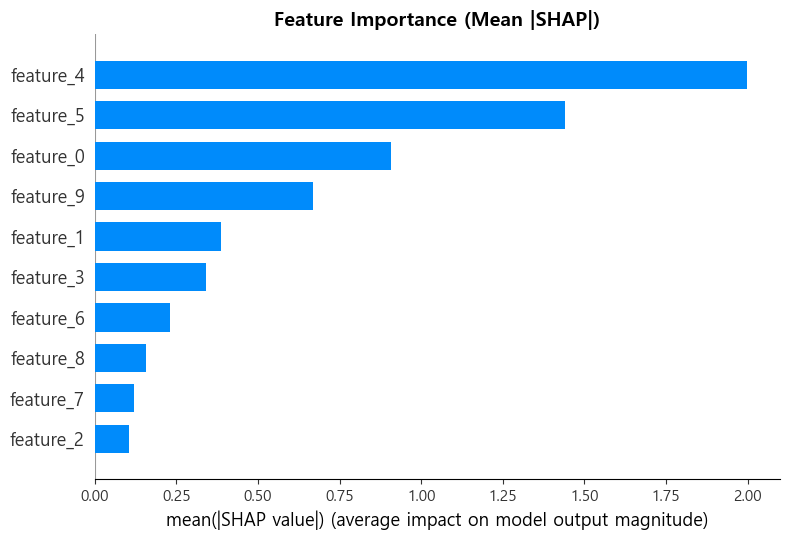


해석:
  - 막대가 길수록 예측에 큰 영향
  - 글로벌 중요도 (전체 데이터 기준)


In [15]:
# 📚 Summary Plot - Bar (글로벌 중요도)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, plot_type='bar', show=False)
plt.title('Feature Importance (Mean |SHAP|)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n해석:")
print("  - 막대가 길수록 예측에 큰 영향")
print("  - 글로벌 중요도 (전체 데이터 기준)")

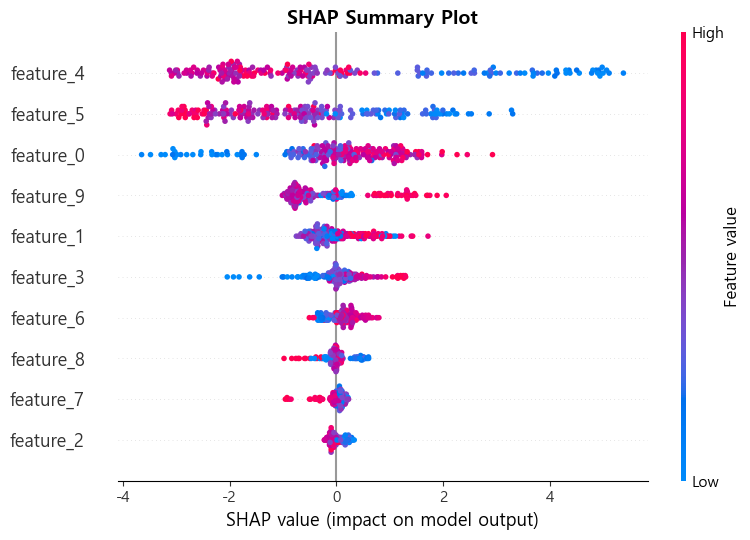


해석:
  - X축: SHAP 값 (양수=예측↑, 음수=예측↓)
  - 색상: 피처 값 (빨강=높음, 파랑=낮음)
  - 점 하나 = 샘플 하나


In [16]:
# 📚 Summary Plot - Dot (분포)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, show=False)
plt.title('SHAP Summary Plot', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n해석:")
print("  - X축: SHAP 값 (양수=예측↑, 음수=예측↓)")
print("  - 색상: 피처 값 (빨강=높음, 파랑=낮음)")
print("  - 점 하나 = 샘플 하나")

### 4-2. Waterfall Plot (개별 예측 분해)

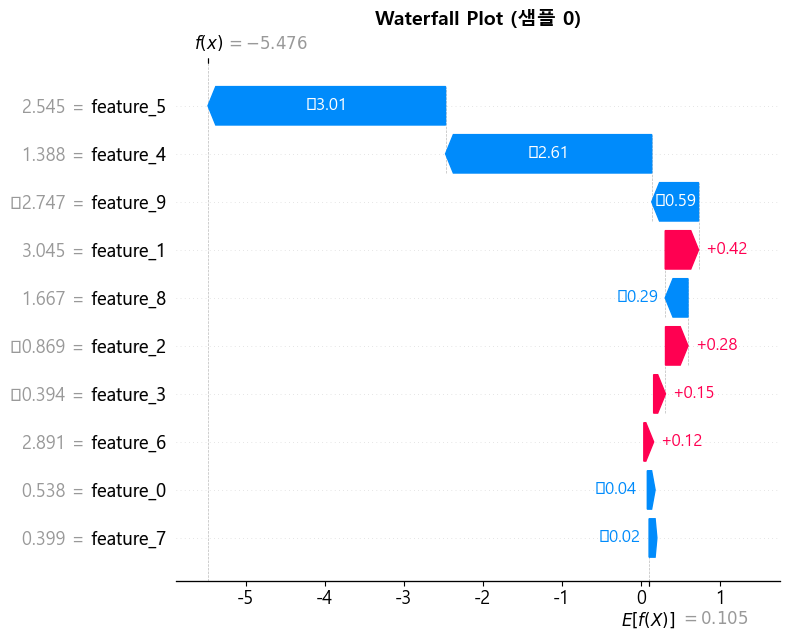


해석:
  - E[f(x)]: 기본값 (평균 예측)
  - 빨간색: 예측값을 높이는 피처
  - 파란색: 예측값을 낮추는 피처
  - f(x): 최종 예측값


In [17]:
# 📚 Waterfall Plot

# 새로운 API 사용
explanation = shap.Explanation(
    values=shap_values[0],
    base_values=get_base_value(explainer),
    data=X_test.iloc[0].values,
    feature_names=feature_names
)

plt.figure(figsize=(10, 6))
shap.waterfall_plot(explanation, show=False)
plt.title('Waterfall Plot (샘플 0)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n해석:")
print("  - E[f(x)]: 기본값 (평균 예측)")
print("  - 빨간색: 예측값을 높이는 피처")
print("  - 파란색: 예측값을 낮추는 피처")
print("  - f(x): 최종 예측값")

### 4-3. Force Plot (예측 기여도)

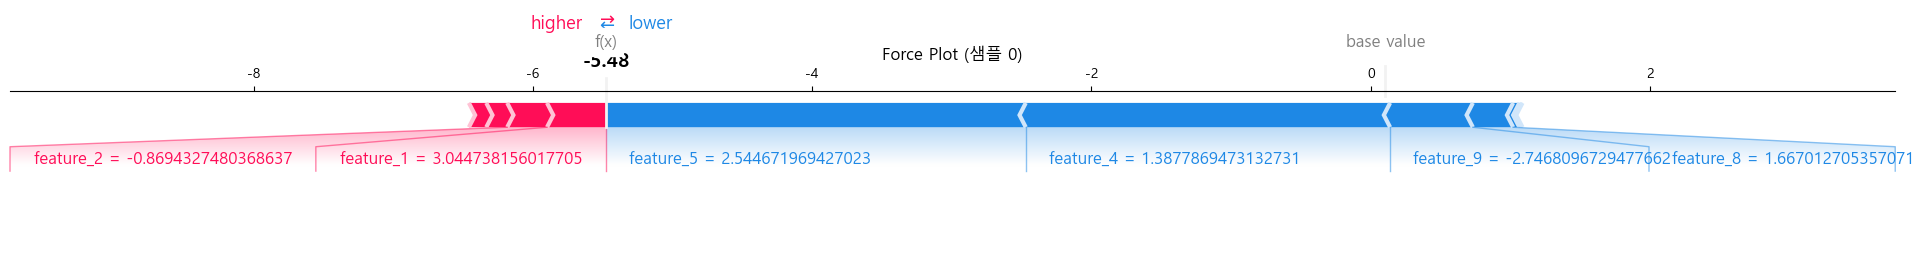


해석:
  - 빨간색: 예측을 높이는 피처 (왼쪽으로 밀어냄)
  - 파란색: 예측을 낮추는 피처 (오른쪽으로 밀어냄)


In [18]:
# 📚 Force Plot (단일 샘플)

# matplotlib 버전
shap.force_plot(
    get_base_value(explainer),
    shap_values[0],
    X_test.iloc[0],
    feature_names=feature_names,
    matplotlib=True,
    show=False
)
plt.title('Force Plot (샘플 0)', fontsize=12)
plt.tight_layout()
plt.show()

print("\n해석:")
print("  - 빨간색: 예측을 높이는 피처 (왼쪽으로 밀어냄)")
print("  - 파란색: 예측을 낮추는 피처 (오른쪽으로 밀어냄)")

### 4-4. Dependence Plot (피처 관계)

<Figure size 1000x600 with 0 Axes>

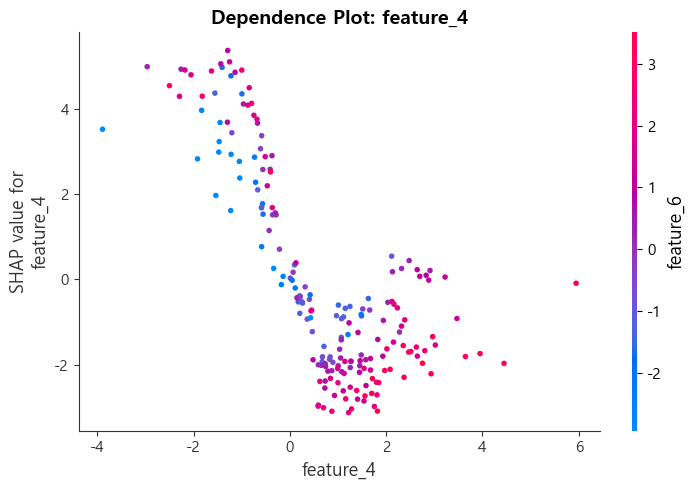


해석 (feature_4):
  - X축: 피처 값
  - Y축: SHAP 값
  - 색상: 상호작용하는 피처


In [19]:
# 📚 Dependence Plot

# 가장 중요한 피처 찾기
mean_shap = np.abs(shap_values).mean(axis=0)
top_feature_idx = np.argmax(mean_shap)
top_feature = feature_names[top_feature_idx]

plt.figure(figsize=(10, 6))
shap.dependence_plot(
    top_feature,
    shap_values,
    X_test,
    feature_names=feature_names,
    show=False
)
plt.title(f'Dependence Plot: {top_feature}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n해석 ({top_feature}):")
print("  - X축: 피처 값")
print("  - Y축: SHAP 값")
print("  - 색상: 상호작용하는 피처")

---
## 5. FDS 적용 예시

In [20]:
# 📚 FDS 시뮬레이션 데이터

np.random.seed(42)

# FDS 피처 생성
n_samples = 1000
fds_data = pd.DataFrame({
    '거래금액': np.random.exponential(50000, n_samples),
    '거래시간': np.random.randint(0, 24, n_samples),
    '해외거래': np.random.binomial(1, 0.1, n_samples),
    '카드사용횟수': np.random.poisson(5, n_samples),
    '최근거래간격': np.random.exponential(24, n_samples),
})

# 사기 라벨 (규칙 기반)
fds_data['isFraud'] = (
    (fds_data['거래금액'] > 200000) & 
    (fds_data['거래시간'].isin([0,1,2,3,4])) &
    (fds_data['해외거래'] == 1)
).astype(int)

# 일부 랜덤 사기 추가
random_fraud = np.random.choice(n_samples, 30, replace=False)
fds_data.loc[random_fraud, 'isFraud'] = 1

print(f"FDS 데이터: {fds_data.shape}")
print(f"사기 비율: {fds_data['isFraud'].mean():.2%}")

FDS 데이터: (1000, 6)
사기 비율: 3.00%


In [21]:
# 📚 FDS 모델 학습

fds_features = ['거래금액', '거래시간', '해외거래', '카드사용횟수', '최근거래간격']
X_fds = fds_data[fds_features]
y_fds = fds_data['isFraud']

X_fds_train, X_fds_test, y_fds_train, y_fds_test = train_test_split(
    X_fds, y_fds, test_size=0.2, random_state=42, stratify=y_fds
)

fds_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    scale_pos_weight=len(y_fds_train[y_fds_train==0]) / len(y_fds_train[y_fds_train==1]),
    random_state=42,
    verbosity=0
)
fds_model.fit(X_fds_train, y_fds_train)

fds_prob = fds_model.predict_proba(X_fds_test)[:, 1]
fds_auc = roc_auc_score(y_fds_test, fds_prob)
print(f"FDS 모델 AUC: {fds_auc:.4f}")

FDS 모델 AUC: 0.6087


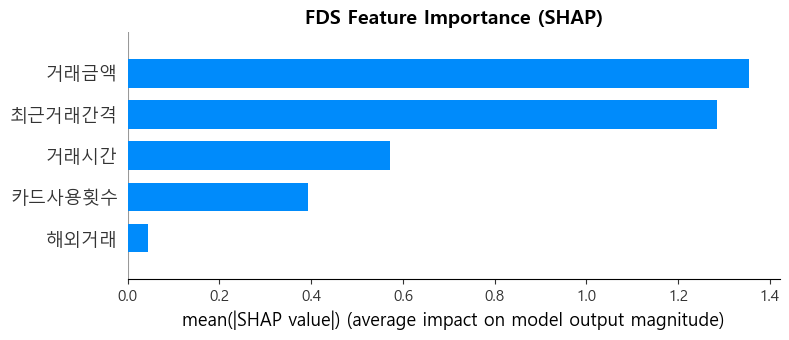

In [22]:
# 📚 FDS SHAP 분석

fds_explainer = shap.TreeExplainer(fds_model)
fds_shap_values = fds_explainer.shap_values(X_fds_test)

# 글로벌 중요도
plt.figure(figsize=(10, 5))
shap.summary_plot(fds_shap_values, X_fds_test, plot_type='bar', show=False)
plt.title('FDS Feature Importance (SHAP)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

사기 의심 거래 분석 (샘플 6):
사기 확률: 80.72%
실제 라벨: 정상

거래 정보:
  거래금액: 49429.68
  거래시간: 22.00
  해외거래: 0.00
  카드사용횟수: 3.00
  최근거래간격: 32.22


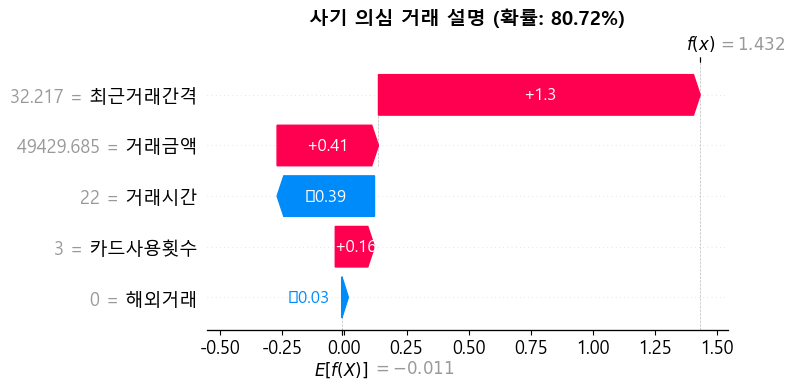

In [23]:
# 📚 사기 거래 설명

# 사기로 예측된 샘플 찾기
fraud_preds = np.where(fds_prob > 0.5)[0]

if len(fraud_preds) > 0:
    fraud_idx = fraud_preds[0]
    
    print(f"사기 의심 거래 분석 (샘플 {fraud_idx}):")
    print("="*50)
    print(f"사기 확률: {fds_prob[fraud_idx]:.2%}")
    print(f"실제 라벨: {'사기' if y_fds_test.iloc[fraud_idx] == 1 else '정상'}")
    print(f"\n거래 정보:")
    for feat in fds_features:
        print(f"  {feat}: {X_fds_test.iloc[fraud_idx][feat]:.2f}")
    
    # Waterfall Plot
    explanation = shap.Explanation(
        values=fds_shap_values[fraud_idx],
        base_values=get_base_value(fds_explainer),
        data=X_fds_test.iloc[fraud_idx].values,
        feature_names=fds_features
    )
    
    plt.figure(figsize=(10, 5))
    shap.waterfall_plot(explanation, show=False)
    plt.title(f'사기 의심 거래 설명 (확률: {fds_prob[fraud_idx]:.2%})', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("사기로 예측된 샘플이 없습니다.")

In [24]:
# 📚 JSON 출력 형태 (API 응답)

if len(fraud_preds) > 0:
    fraud_idx = fraud_preds[0]
    
    # Top 3 기여 피처
    shap_dict = dict(zip(fds_features, fds_shap_values[fraud_idx]))
    sorted_shap = sorted(shap_dict.items(), key=lambda x: abs(x[1]), reverse=True)
    
    fds_base = get_base_value(fds_explainer)
    api_response = {
        "fraud_probability": float(fds_prob[fraud_idx]),
        "is_fraud": bool(fds_prob[fraud_idx] > 0.5),
        "top_factors": [
            {
                "feature": feat,
                "impact": float(val),
                "value": float(X_fds_test.iloc[fraud_idx][feat])
            }
            for feat, val in sorted_shap[:3]
        ],
        "base_probability": float(1 / (1 + np.exp(-fds_base)))
    }
    
    import json
    print("API 응답 예시:")
    print(json.dumps(api_response, indent=2, ensure_ascii=False))

API 응답 예시:
{
  "fraud_probability": 0.8072283267974854,
  "is_fraud": true,
  "top_factors": [
    {
      "feature": "최근거래간격",
      "impact": 1.2951620817184448,
      "value": 32.2172344604531
    },
    {
      "feature": "거래금액",
      "impact": 0.408062607049942,
      "value": 49429.68451836482
    },
    {
      "feature": "거래시간",
      "impact": -0.3922460675239563,
      "value": 22.0
    }
  ],
  "base_probability": 0.4972194812976262
}


---
## 면접 Q&A

### Q: "SHAP vs Feature Importance 차이점?"

> "Feature Importance는 글로벌한 중요도만 제공하지만,
> SHAP은 개별 예측을 설명할 수 있습니다.
> 또한 SHAP은 방향성(+/-)을 알 수 있어서
> '왜 이 거래가 사기인가'를 구체적으로 설명할 수 있습니다.
> 금융 규제상 모델 설명이 필수이므로 SHAP을 선택했습니다."

### Q: "TreeExplainer가 빠른 이유?"

> "일반 SHAP은 모든 피처 조합을 계산해서 O(2^n) 복잡도입니다.
> TreeExplainer는 트리 구조를 활용해서 효율적으로 계산합니다.
> 트리의 분기 경로를 따라가며 기여도를 계산하므로
> 정확한 SHAP 값을 빠르게 얻을 수 있습니다."

### Q: "왜 FDS에 SHAP을 적용했나요?"

> "세 가지 이유가 있습니다.
> 첫째, 금융권 규제로 AI 모델 설명이 의무화되고 있습니다.
> 둘째, 고객에게 '왜 거래가 차단됐는지' 설명해야 민원이 줄어듭니다.
> 셋째, 분석가가 모델의 판단 근거를 검토할 수 있어 신뢰도가 높아집니다."

### Q: "LSTM에도 SHAP을 적용할 수 있나요?"

> "네, DeepExplainer나 GradientExplainer를 사용합니다.
> 다만 TreeExplainer만큼 빠르지는 않고, 근사값입니다.
> 실무에서는 XGBoost SHAP을 메인으로 쓰고,
> LSTM은 시퀀스 패턴 탐지에만 활용하는 방식을 선택했습니다."

---
## 최종 체크포인트

In [ ]:
print("="*60)
print("  1-S6 완료: SHAP 기초")
print("="*60)
print()
print("배운 것:")
print()
print("1. SHAP 개념")
print("   - Shapley Value 기반 공정한 기여도 분배")
print("   - 로컬 + 글로벌 설명 가능")
print("   - 합이 예측값과 일치")
print()
print("2. Explainer 종류")
print("   - TreeExplainer: XGBoost, LightGBM (빠름)")
print("   - DeepExplainer: 딥러닝 모델")
print("   - KernelExplainer: 모든 모델 (느림)")
print()
print("3. SHAP 시각화")
print("   - summary_plot: 전체 중요도")
print("   - waterfall_plot: 개별 예측 분해")
print("   - force_plot: 예측 기여도")
print("   - dependence_plot: 피처 관계")
print()
print("4. FDS 적용")
print("   - 사기 거래 설명: '왜 사기인가?'")
print("   - API 응답에 top_factors 포함")
print()
print("="*60)
print("다음: 1-6 SHAP 구현 (실제 XGBoost 모델 적용)")
print("="*60)